<a href="https://colab.research.google.com/github/aslamrosul/PBL-SEM5-Test-Flask-API/blob/main/PBLSMS5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libary

In [1]:
!python --version

Python 3.12.12


In [2]:
!pip install skl2onnx onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.1 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.metrics import accuracy_score, classification_report
import onnx
import warnings
import joblib
import random
import onnxruntime as ort
from google.colab import files

warnings.filterwarnings('ignore')

# Load Gambar

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import cv2
import numpy as np

def load_dataset(directory, img_size=(256, 256)):
    data = []
    labels = []

    # urutan kelas harus konsisten
    class_names = sorted(os.listdir(directory))
    print("Urutan kelas:", class_names)

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)

        if not os.path.isdir(class_folder):
            continue

        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            data.append(img)
            labels.append(label)

    return np.array(data), np.array(labels), class_names

In [7]:
train_dir = "/content/drive/MyDrive/PBL_Dataset_Daun/train"
test_dir  = "/content/drive/MyDrive/PBL_Dataset_Daun/test"

X_train, y_train, class_names = load_dataset(train_dir)
X_test, y_test, _ = load_dataset(test_dir)

print("Train data :", X_train.shape)
print("Test data  :", X_test.shape)
print("Classes    :", class_names)


Urutan kelas: ['melengkung', 'menjari', 'menyirip', 'sejajar']
Urutan kelas: ['melengkung', 'menjari', 'menyirip', 'sejajar']
Train data : (1364, 256, 256, 3)
Test data  : (300, 256, 256, 3)
Classes    : ['melengkung', 'menjari', 'menyirip', 'sejajar']


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy for concatenation if not already in scope

# Combine X_train and X_test to form the full images dataset
images = np.concatenate((X_train, X_test), axis=0)

# Combine y_train and y_test to form the full labels dataset
labels = np.concatenate((y_train, y_test), axis=0)

X_train_img_73, X_test_img_73, y_train_str_73, y_test_str_73 = train_test_split(
    images,
    labels,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

print(f"Jumlah Sampel Training (70%): {len(X_train_img_73)}")
print(f"Jumlah Sampel Testing (30%): {len(X_test_img_73)}")

Jumlah Sampel Training (70%): 1164
Jumlah Sampel Testing (30%): 500


In [9]:
X_train_img_82, X_test_img_82, y_train_str_82, y_test_str_82 = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Jumlah Sampel Training (80%): {len(X_train_img_82)}")
print(f"Jumlah Sampel Testing (20%): {len(X_test_img_82)}")

Jumlah Sampel Training (80%): 1331
Jumlah Sampel Testing (20%): 333


In [10]:
X_train_img_91, X_test_img_91, y_train_str_91, y_test_str_91 = train_test_split(
    images,
    labels,
    test_size=0.1,
    random_state=42,
    stratify=labels
)

print(f"Jumlah Sampel Training (90%): {len(X_train_img_91)}")
print(f"Jumlah Sampel Testing (10%): {len(X_test_img_91)}")

Jumlah Sampel Training (90%): 1497
Jumlah Sampel Testing (10%): 167


# Pre-processing (HSV)

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern

def remove_white_background(img):
    # Konversi ke HSV agar lebih stabil deteksi putih
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Mask warna putih
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    # Balik mask (ambil objek)
    fg_mask = cv2.bitwise_not(mask_white)
    img_nobg = cv2.bitwise_and(img, img, mask=fg_mask)

    return img_nobg, fg_mask

def show_histogram_with_shape_features(images, labels, class_names, max_show=4):
    n = min(len(images), max_show)

    plt.figure(figsize=(15, 5*n))

    for i in range(n):
        img = images[i]

        # ================= REMOVE BACKGROUND =================
        img_nobg, mask = remove_white_background(img)

        # RGB & GRAY
        img_rgb = cv2.cvtColor(img_nobg, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_nobg, cv2.COLOR_BGR2GRAY)

        # ================= Gambar hasil =================
        plt.subplot(n, 4, i*4 + 1)
        plt.imshow(img_rgb)
        plt.title(f"Object Only - {class_names[labels[i]]}")
        plt.axis('off')

        # ================= Histogram RGB =================
        plt.subplot(n, 4, i*4 + 2)
        colors = ('r', 'g', 'b')
        for ch, color in enumerate(colors):
            hist = cv2.calcHist([img_rgb], [ch], mask, [256], [0, 256])
            plt.plot(hist, color=color)

        plt.title("RGB Histogram (No Background)")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


In [32]:
list_label = [
    'melengkung',
    'menjari',
    'menyirip',
    'sejajar'
]

# Gunakan convert hanya jika label masih numeric
def convert_numeric_to_label(y_numeric, label_map):
    return [label_map[int(i)] for i in y_numeric]

# Hanya jalankan convert kalau label masih angka (np.int64)
if isinstance(list(y_train_str_73)[0], (int, np.integer)):
    y_train_str_73 = convert_numeric_to_label(y_train_str_73, list_label)

if isinstance(list(y_test_str_73)[0], (int, np.integer)):
    y_test_str_73  = convert_numeric_to_label(y_test_str_73, list_label)

if isinstance(list(y_train_str_82)[0], (int, np.integer)):
    y_train_str_82 = convert_numeric_to_label(y_train_str_82, list_label)

if isinstance(list(y_test_str_82)[0], (int, np.integer)):
    y_test_str_82  = convert_numeric_to_label(y_test_str_82, list_label)

if isinstance(list(y_train_str_91)[0], (int, np.integer)):
    y_train_str_91 = convert_numeric_to_label(y_train_str_91, list_label)

if isinstance(list(y_test_str_91)[0], (int, np.integer)):
    y_test_str_91  = convert_numeric_to_label(y_test_str_91, list_label)


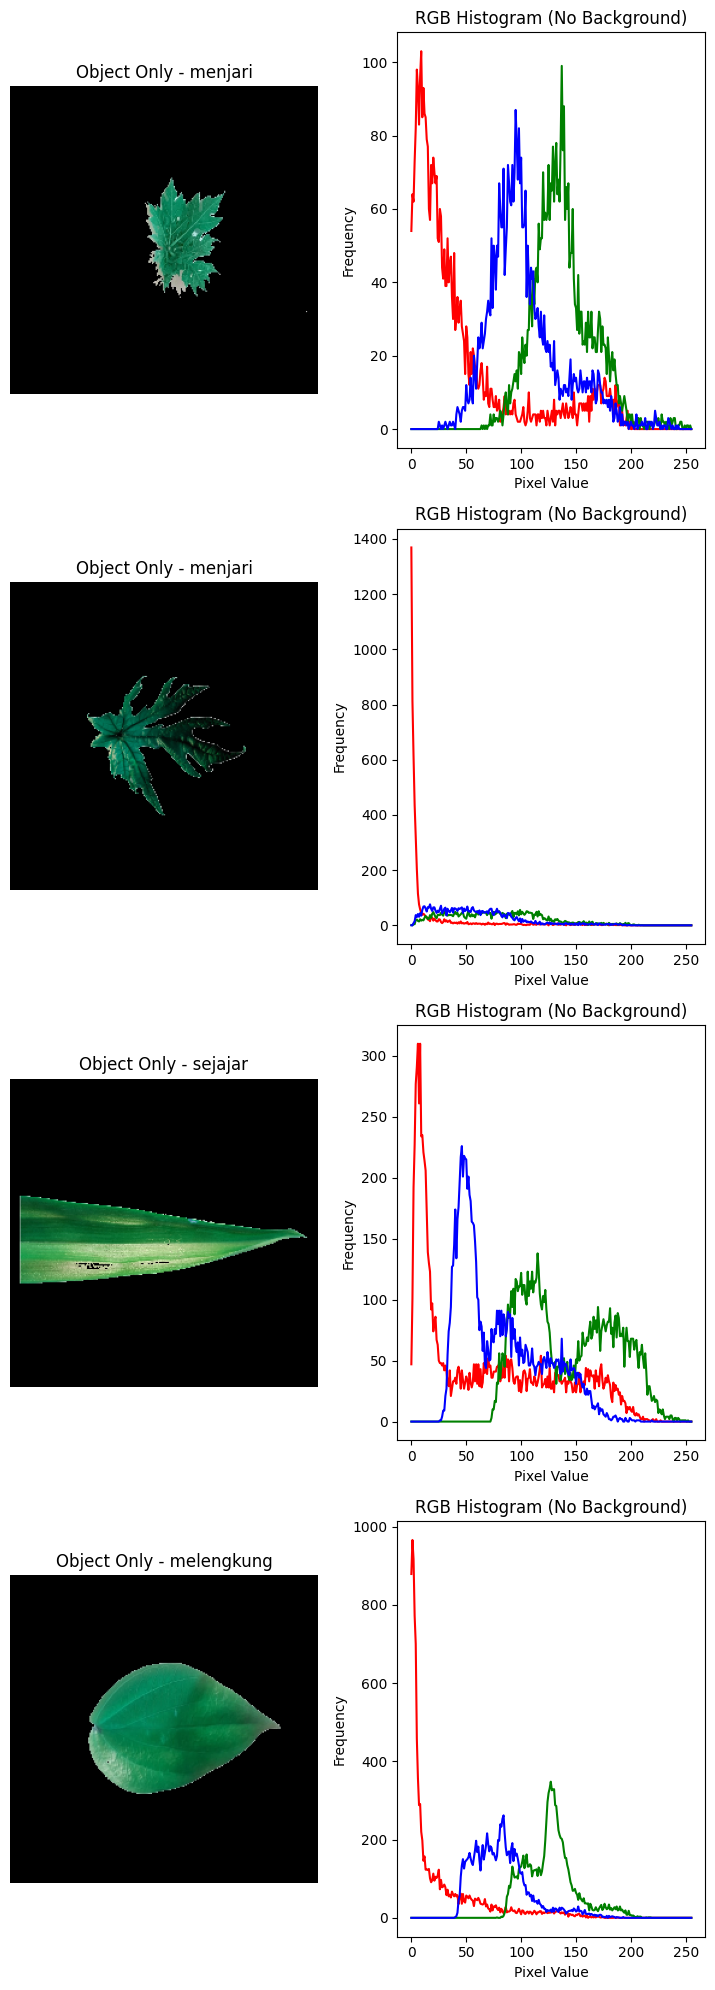

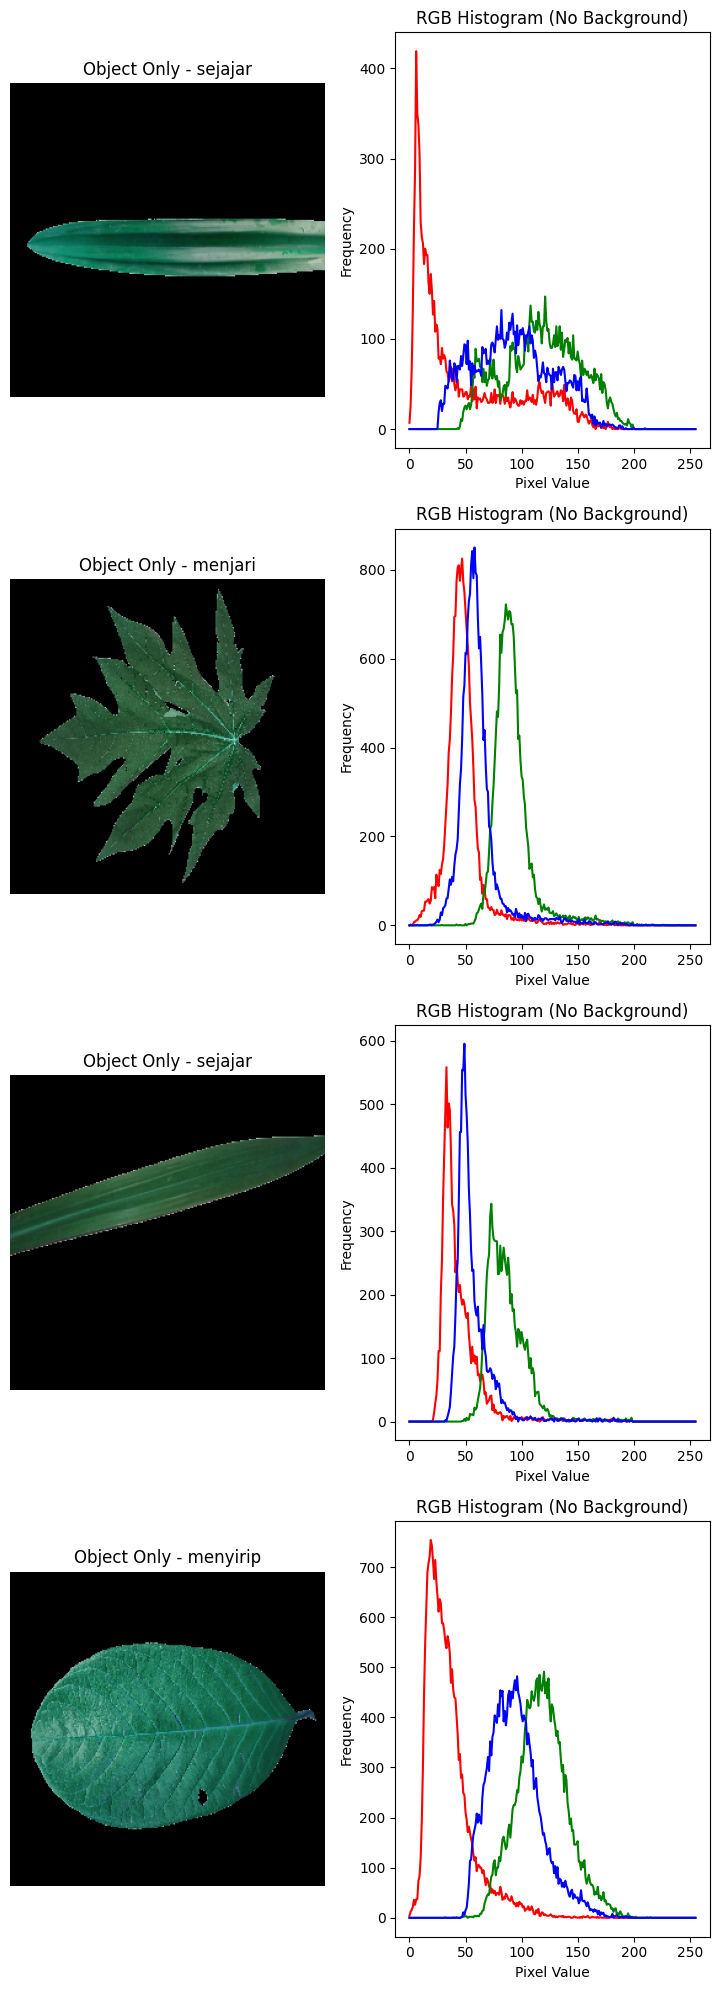

In [33]:
# Create a mapping from string labels to their integer indices
label_to_numeric = {name: i for i, name in enumerate(list_label)}

# Convert string labels back to numerical labels for train_73
y_train_numeric_73 = [label_to_numeric[lbl] for lbl in y_train_str_73]

# Convert string labels back to numerical labels for test_73
y_test_numeric_73 = [label_to_numeric[lbl] for lbl in y_test_str_73]

# Call the function with numerical labels
train_hsv_73 = show_histogram_with_shape_features(X_train_img_73, y_train_numeric_73, list_label)
test_hsv_73  = show_histogram_with_shape_features(X_test_img_73, y_test_numeric_73, list_label)

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern

def remove_white_background(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    fg_mask = cv2.bitwise_not(mask_white)
    img_nobg = cv2.bitwise_and(img, img, mask=fg_mask)

    return img_nobg, fg_mask

def show_features_with_hog_graph(images, labels, class_names, max_show=4):
    n = min(len(images), max_show)

    plt.figure(figsize=(16, 5*n))

    for i in range(n):
        img = images[i]

        # Remove background
        img_nobg, mask = remove_white_background(img)

        img_rgb = cv2.cvtColor(img_nobg, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_nobg, cv2.COLOR_BGR2GRAY)

        # ================= 1. Gambar =================
        plt.subplot(n, 4, i*4 + 1)
        plt.imshow(img_rgb)
        plt.title(f"Object Only - {class_names[labels[i]]}")
        plt.axis('off')

        # ================= 2. Histogram RGB =================
        plt.subplot(n, 4, i*4 + 2)
        colors = ('r', 'g', 'b')
        for ch, color in enumerate(colors):
            hist = cv2.calcHist([img_rgb], [ch], mask, [256], [0,256])
            plt.plot(hist, color=color)

        plt.title("RGB Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        # ================= 3. HOG dalam bentuk grafik =================
        plt.subplot(n, 4, i*4 + 3)

        hog_features = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8,8),
            cells_per_block=(2,2),
            visualize=False,
            feature_vector=True
        )

        # Buat histogram dari fitur HOG
        hog_hist, _ = np.histogram(hog_features, bins=50)

        plt.plot(hog_hist)
        plt.title("HOG Feature Graph (Shape)")
        plt.xlabel("Bins")
        plt.ylabel("Magnitude")

        # ================= 4. LBP =================
        plt.subplot(n, 4, i*4 + 4)

        radius = 1
        n_points = 8 * radius
        lbp = local_binary_pattern(img_gray, n_points, radius, method='uniform')

        plt.imshow(lbp, cmap='gray')
        plt.title("LBP Texture")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


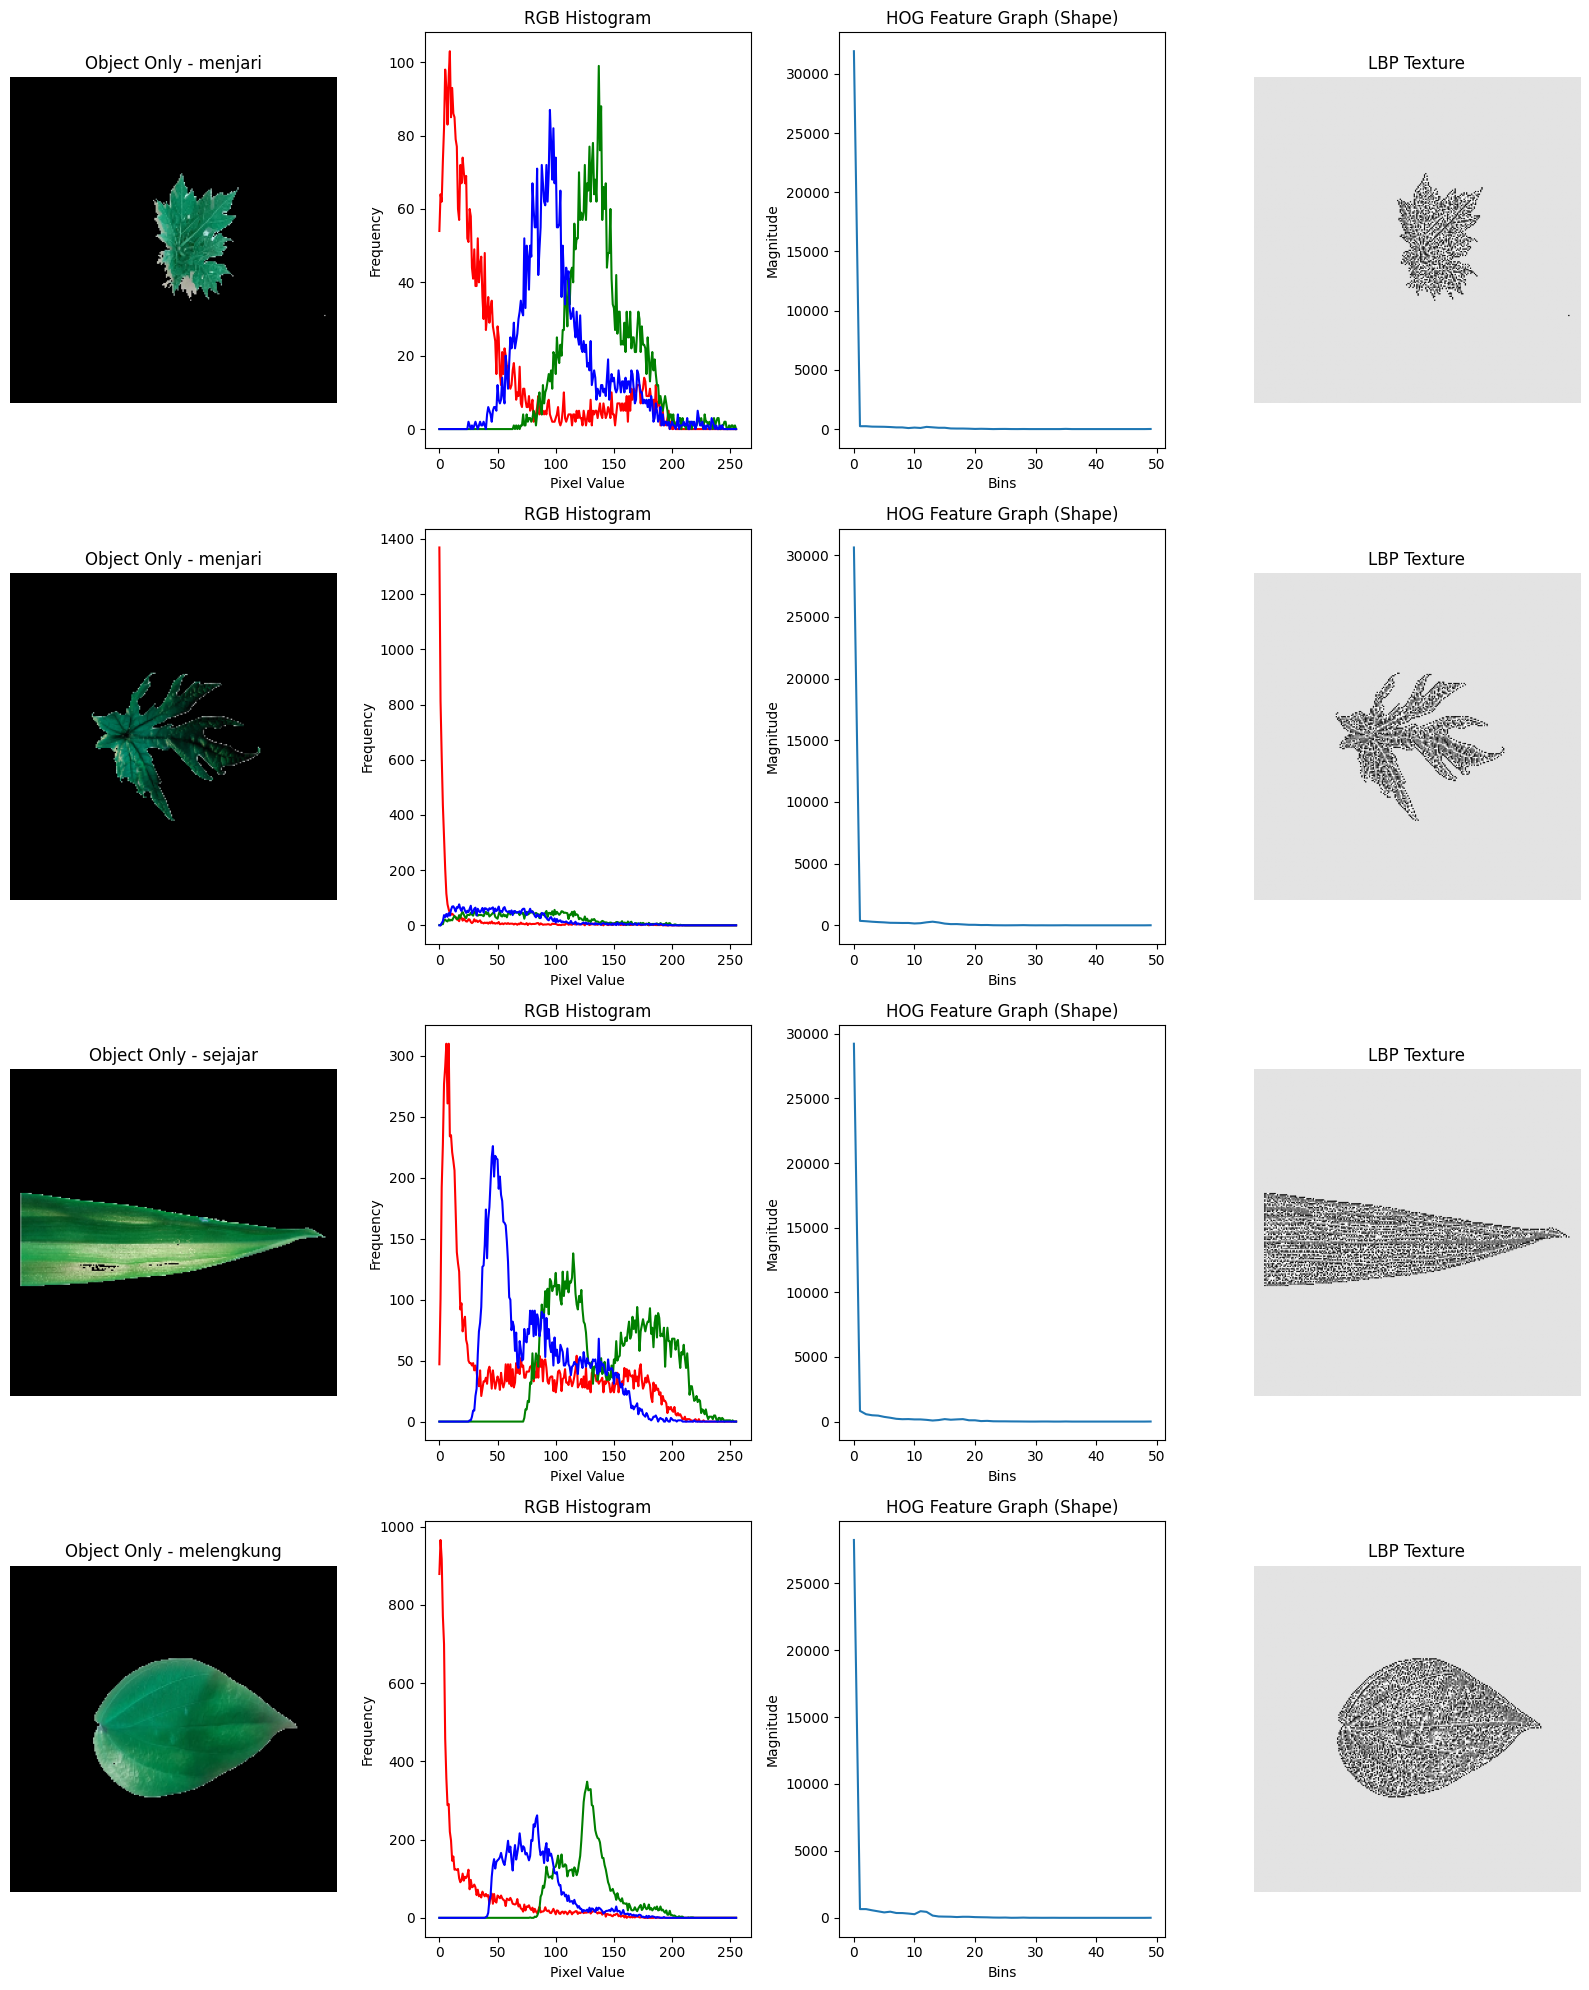

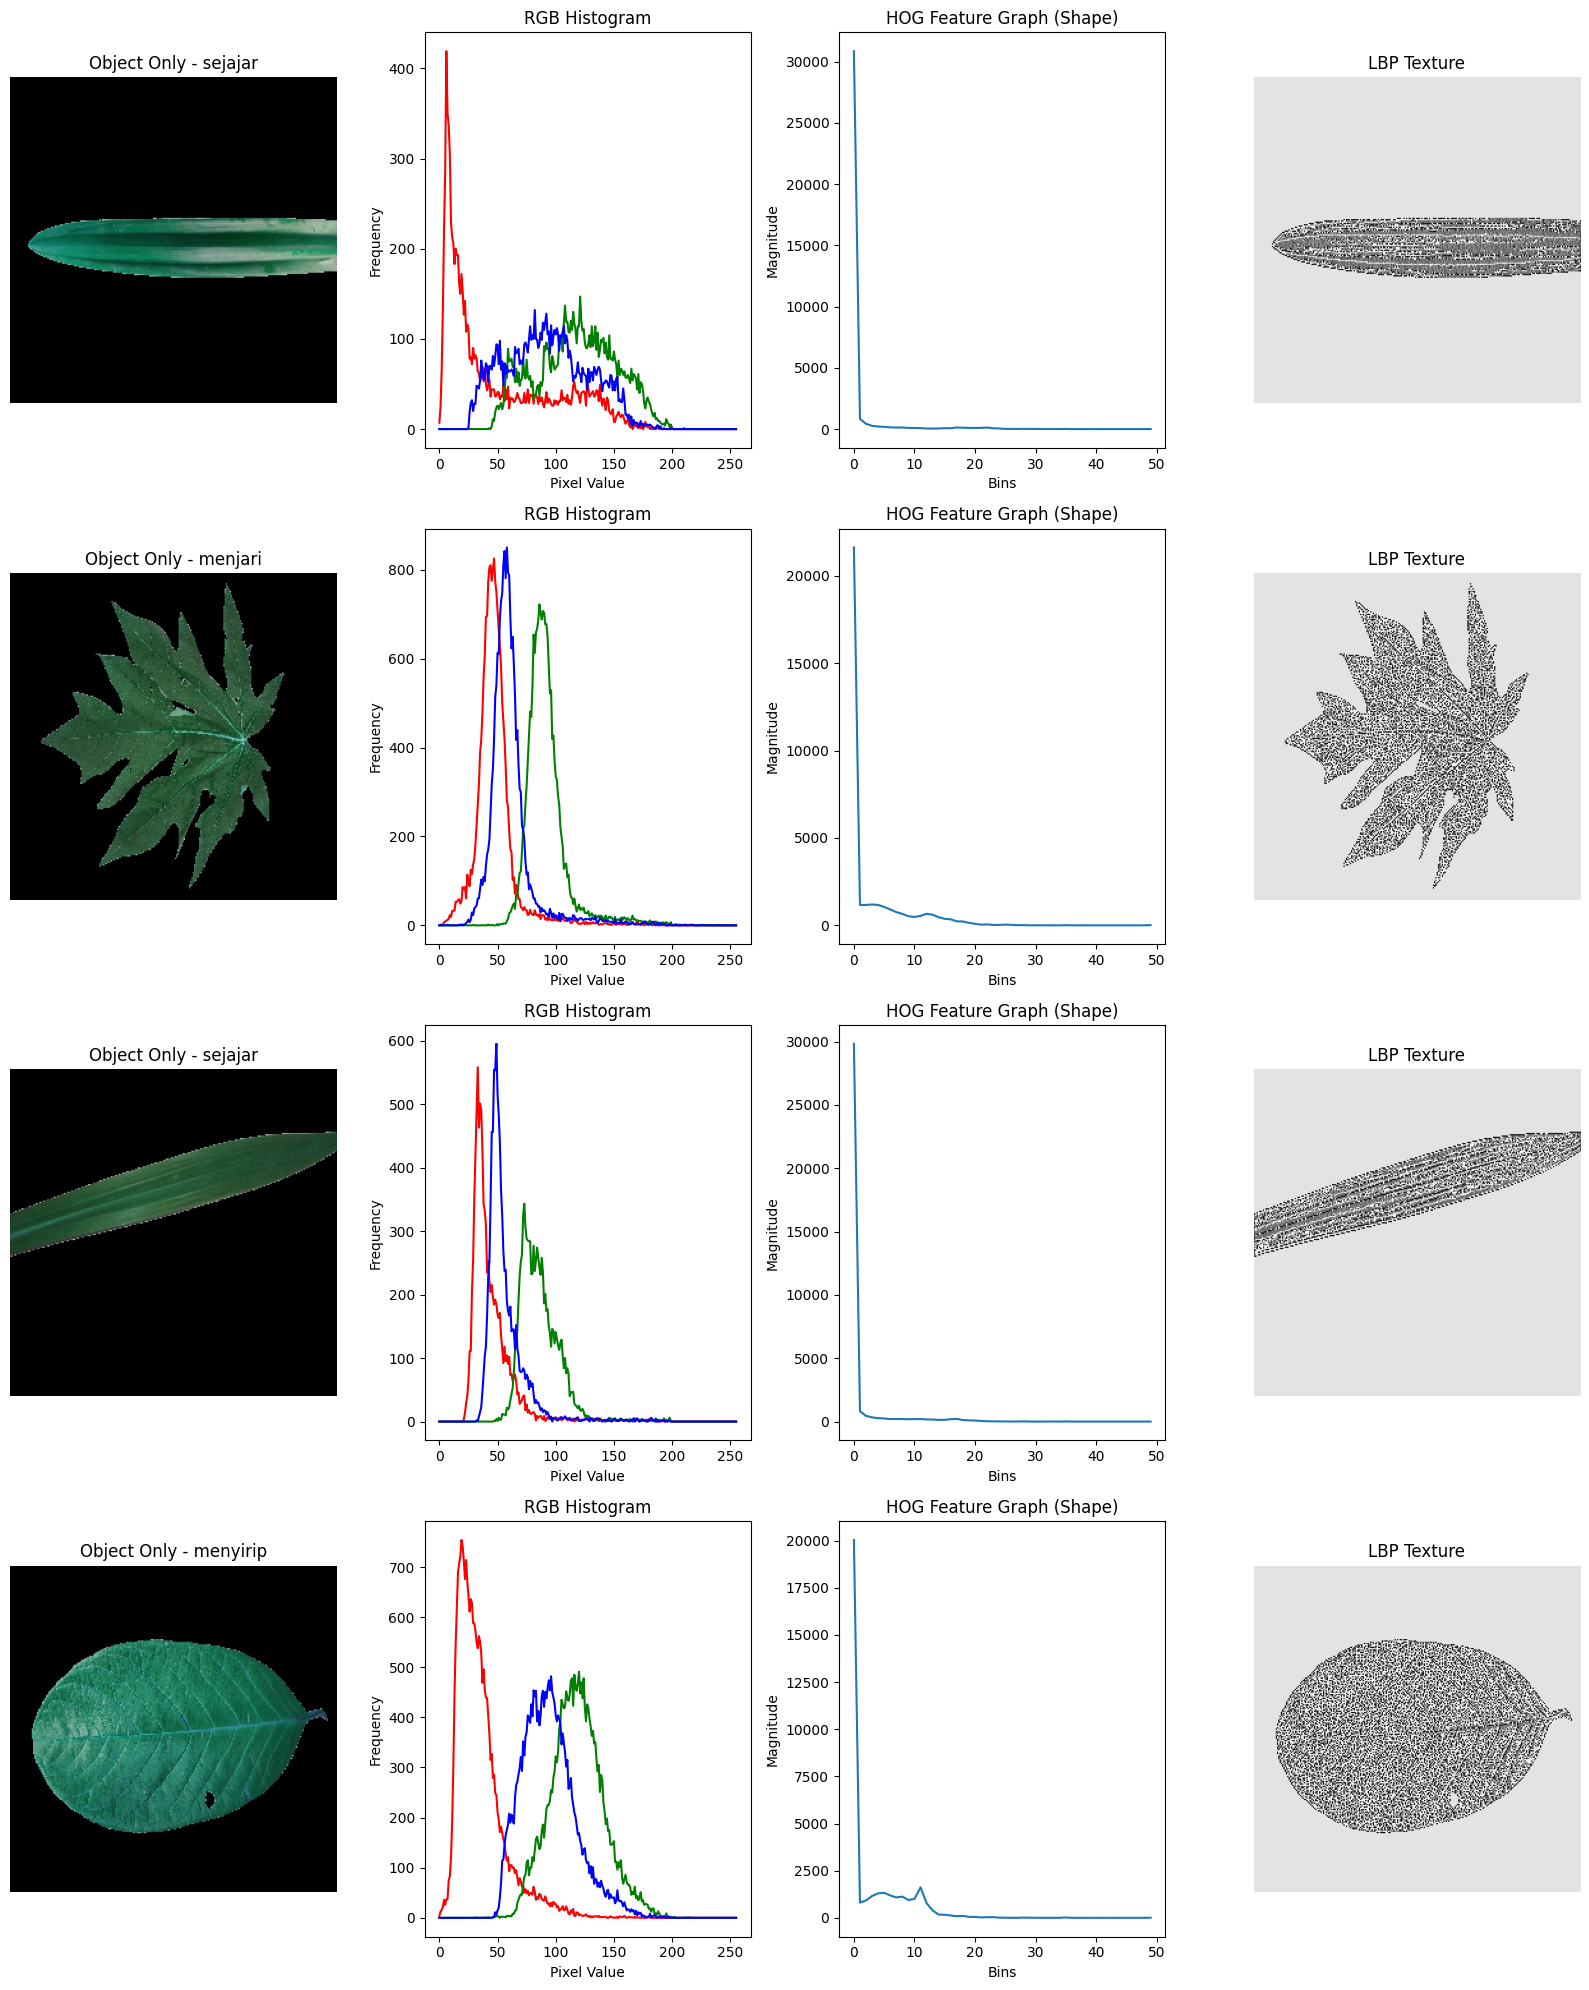

In [37]:
# Create a mapping from string labels to their integer indices
label_to_numeric = {name: i for i, name in enumerate(list_label)}

# Convert string labels back to numerical labels for train_73
y_train_numeric_73 = [label_to_numeric[lbl] for lbl in y_train_str_73]

# Convert string labels back to numerical labels for test_73
y_test_numeric_73 = [label_to_numeric[lbl] for lbl in y_test_str_73]

# Call the function with numerical labels
train_hsv_73 = show_features_with_hog_graph(X_train_img_73, y_train_numeric_73, list_label)
test_hsv_73  = show_features_with_hog_graph(X_test_img_73, y_test_numeric_73, list_label)

In [ ]:
def hsv_preprocessing(images, labels, label_map):
    hsv_img_list = []
    class_list = list_label.copy()
    for i, l in zip(images, labels):
      hsv_image = cv2.cvtColor(i, cv2.COLOR_BGR2HSV)
      color_hist = cv2.calcHist([hsv_image], [0, 1], None, [16, 8], [0, 180, 0, 256])

      cv2.normalize(color_hist, color_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

      color_features = color_hist.flatten()

      hsv_img_list.append(color_features)

      if l in class_list:
        class_list.remove(l)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"Analisis Gambar (Kelas: {l})", fontsize=16)

        img_rgb = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        axes[0].imshow(img_rgb)
        axes[0].set_title("1. Gambar Asli (RGB)")
        axes[0].axis('off')

        h_channel = hsv_image[:, :, 0]

        axes[1].hist(h_channel.flatten(), bins=180, range=[0, 180], color='red')
        axes[1].set_title("2. Histogram Persebaran Warna (Hue)")
        axes[1].set_xlabel("Nilai Hue (0-179)")
        axes[1].set_ylabel("Jumlah Piksel")
        axes[1].set_xlim([0, 180])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show() # Commented out to prevent interruptions

    return hsv_img_list

In [ ]:
print(sorted(set(y_train_str_73)))


['melengkung', 'menjari', 'menyirip', 'sejajar']


In [ ]:
print("Tipe isi:", type(y_train_str_73[0]))
print("Unique labels:", sorted(set(y_train_str_73)))


Tipe isi: <class 'str'>
Unique labels: ['melengkung', 'menjari', 'menyirip', 'sejajar']


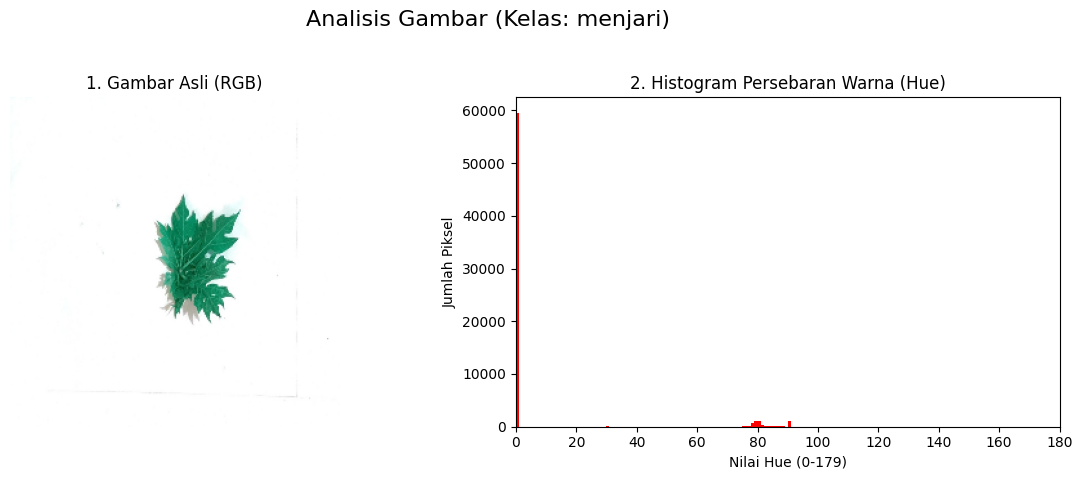

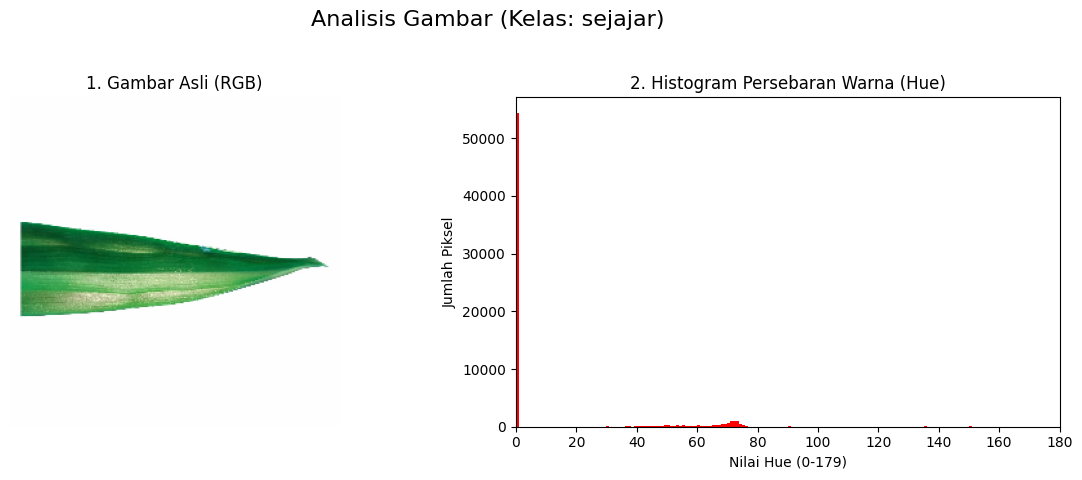

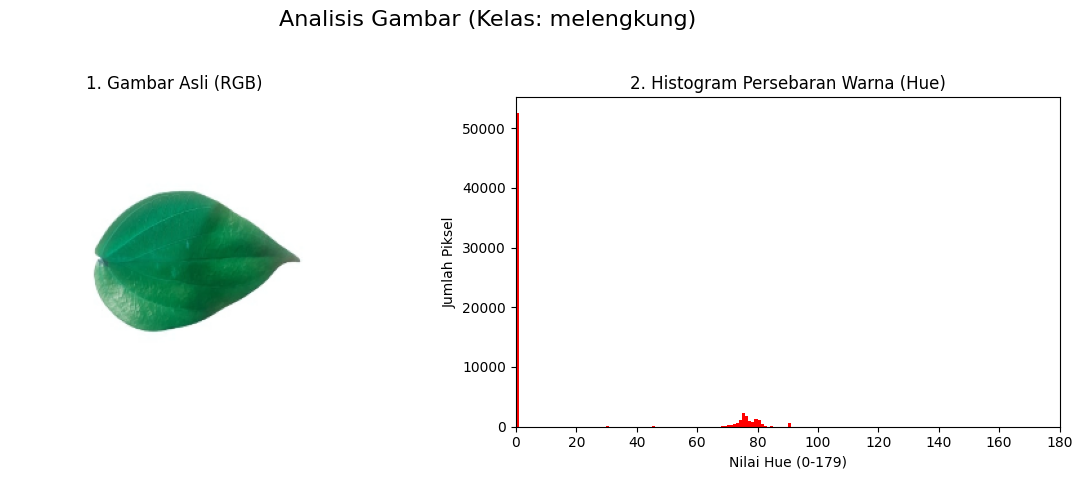

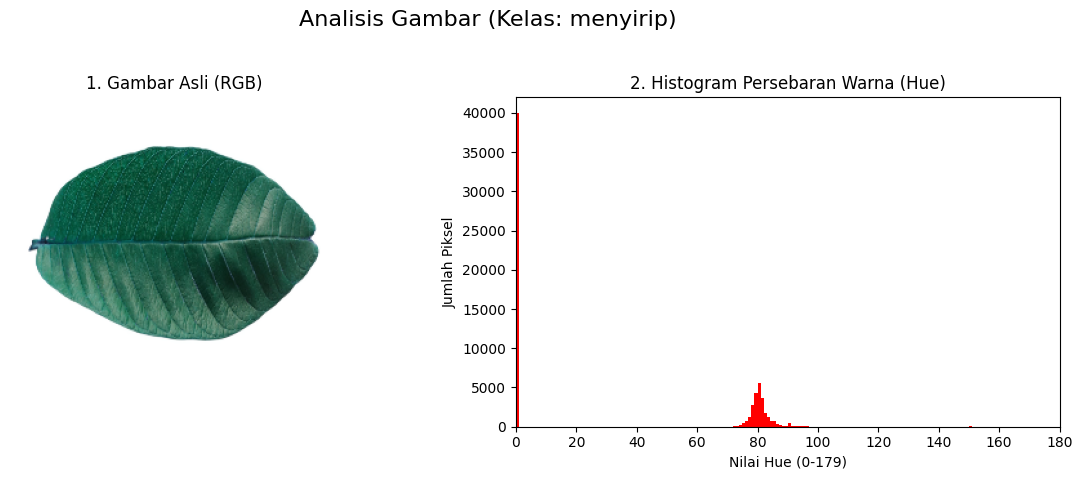

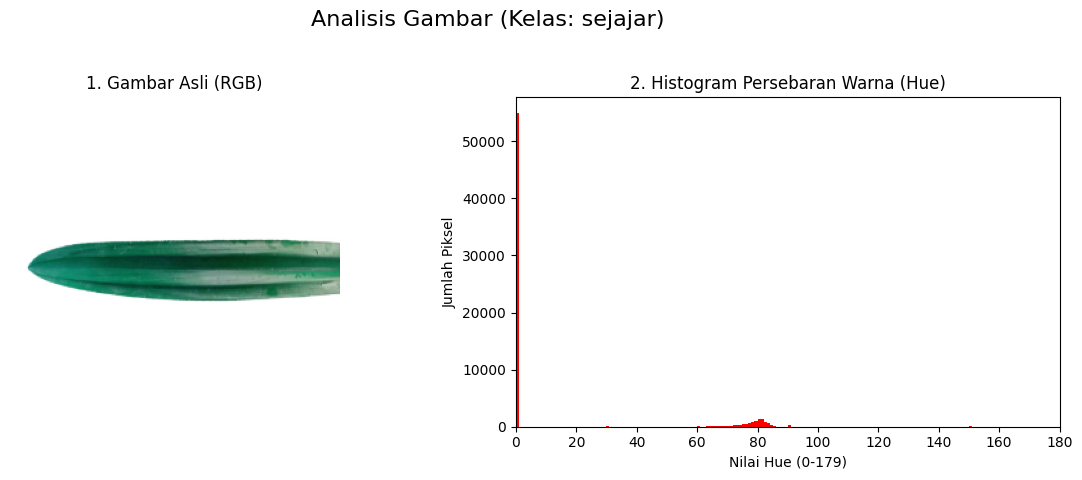

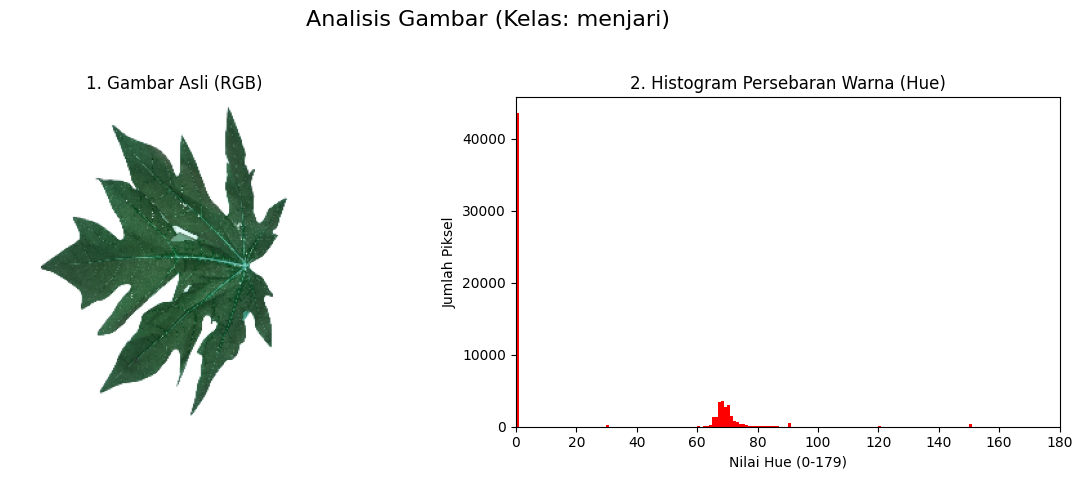

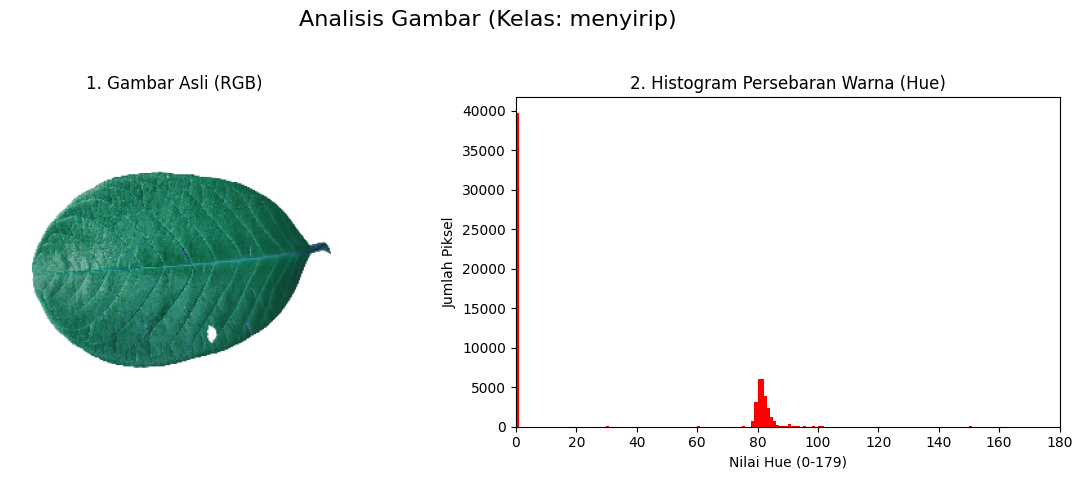

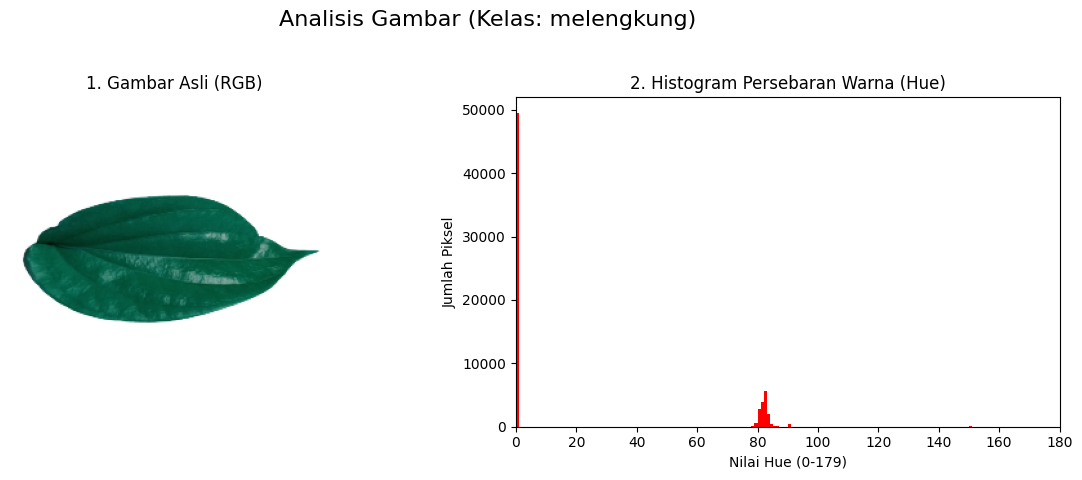

In [ ]:
train_hsv_73 = hsv_preprocessing(X_train_img_73, y_train_str_73, list_label)
test_hsv_73  = hsv_preprocessing(X_test_img_73, y_test_str_73, list_label)

In [ ]:
train_hsv_82 = hsv_preprocessing(X_train_img_82, y_train_str_82, list_label)
test_hsv_82 = hsv_preprocessing(X_test_img_82, y_test_str_82, list_label)

In [ ]:
train_hsv_91 = hsv_preprocessing(X_train_img_91, y_train_str_91, list_label)
test_hsv_91 = hsv_preprocessing(X_test_img_91, y_test_str_91, list_label)

#HOG

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import hog
import cv2
import numpy as np
import matplotlib.pyplot as plt

def homomorphic_filter(img_gray):
    img_log = np.log1p(img_gray)
    M, N = img_log.shape
    sigma = 30

    # High-pass filter in frequency domain
    X, Y = np.mgrid[0:M, 0:N]
    center_x, center_y = M/2, N/2
    gaussian = np.exp(-((X-center_x)**2 + (Y-center_y)**2) / (2*sigma*sigma))
    H = 1 - gaussian

    img_fft = np.fft.fft2(img_log)
    img_filt = np.fft.ifft2(img_fft * H)
    img_exp = np.exp(np.real(img_filt))
    img_norm = cv2.normalize(img_exp, None, 0, 1, cv2.NORM_MINMAX)

    return img_norm


def hog_feature_extraction(images, labels, list_label):
    hog_img_list = []
    class_list = list_label.copy()

    for img, label in zip(images, labels):

        # Convert BGR → RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Grayscale
        gray = rgb2gray(img_rgb)

        # ====== Tambahan: Gamma Correction ======
        gamma = 0.7  # memperjelas detail
        gray_gamma = np.power(gray, gamma)

        # ====== Tambahan: Homomorphic Filter ======
        gray_homo = homomorphic_filter(gray_gamma)

        # Sedikit smoothing supaya noise hilang
        blur = cv2.GaussianBlur((gray_homo * 255).astype(np.uint8), (3, 3), 0)

        # === Canny Edge Detection (lebih jelas kapiler) ===
        edges = cv2.Canny(blur, 40, 120)

        # HOG Feature extraction
        hog_features, hog_visual = hog(
            edges,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True
        )

        hog_img_list.append(hog_features)

        # --- Visualisasi (satu per class) ---
        if label in class_list:
            class_list.remove(label)

            fig, axes = plt.subplots(1, 6, figsize=(26, 5))
            fig.suptitle(f"Visualisasi Ekstraksi Fitur {label}", fontsize=16)

            axes[0].imshow(img_rgb)
            axes[0].set_title("Asli")
            axes[0].axis("off")

            axes[1].imshow(gray, cmap="gray")
            axes[1].set_title("Gray")
            axes[1].axis("off")

            axes[2].imshow(gray_gamma, cmap="gray")
            axes[2].set_title("Gamma Corrected")
            axes[2].axis("off")

            axes[3].imshow(gray_homo, cmap="gray")
            axes[3].set_title("Homomorphic Filter")
            axes[3].axis("off")

            axes[4].imshow(edges, cmap="gray")
            axes[4].set_title("Canny Edge")
            axes[4].axis("off")

            axes[5].imshow(hog_visual, cmap="gray")
            axes[5].set_title("HOG")
            axes[5].axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.90])
            plt.show()

    return hog_img_list


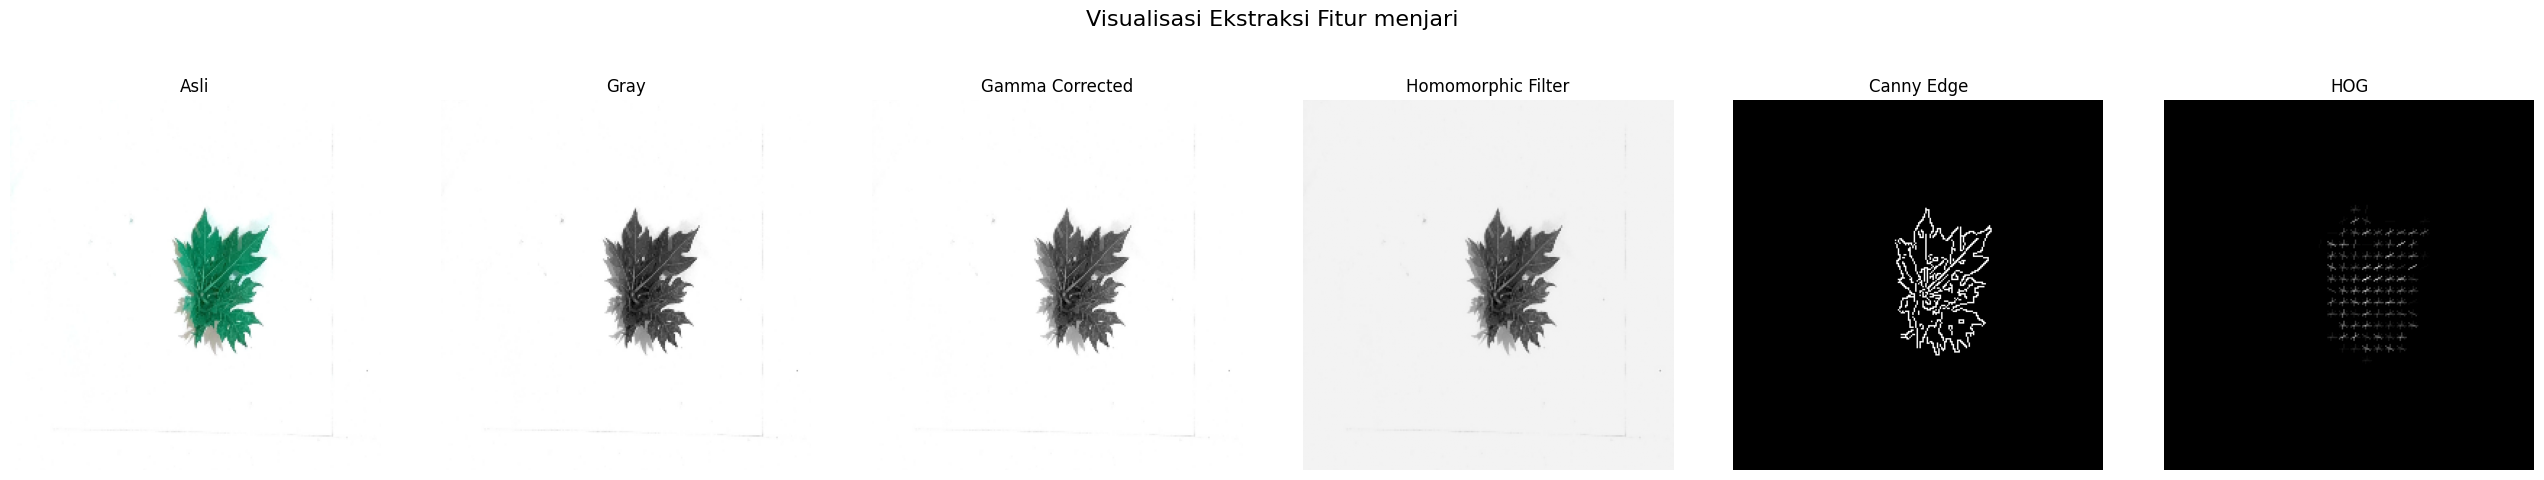

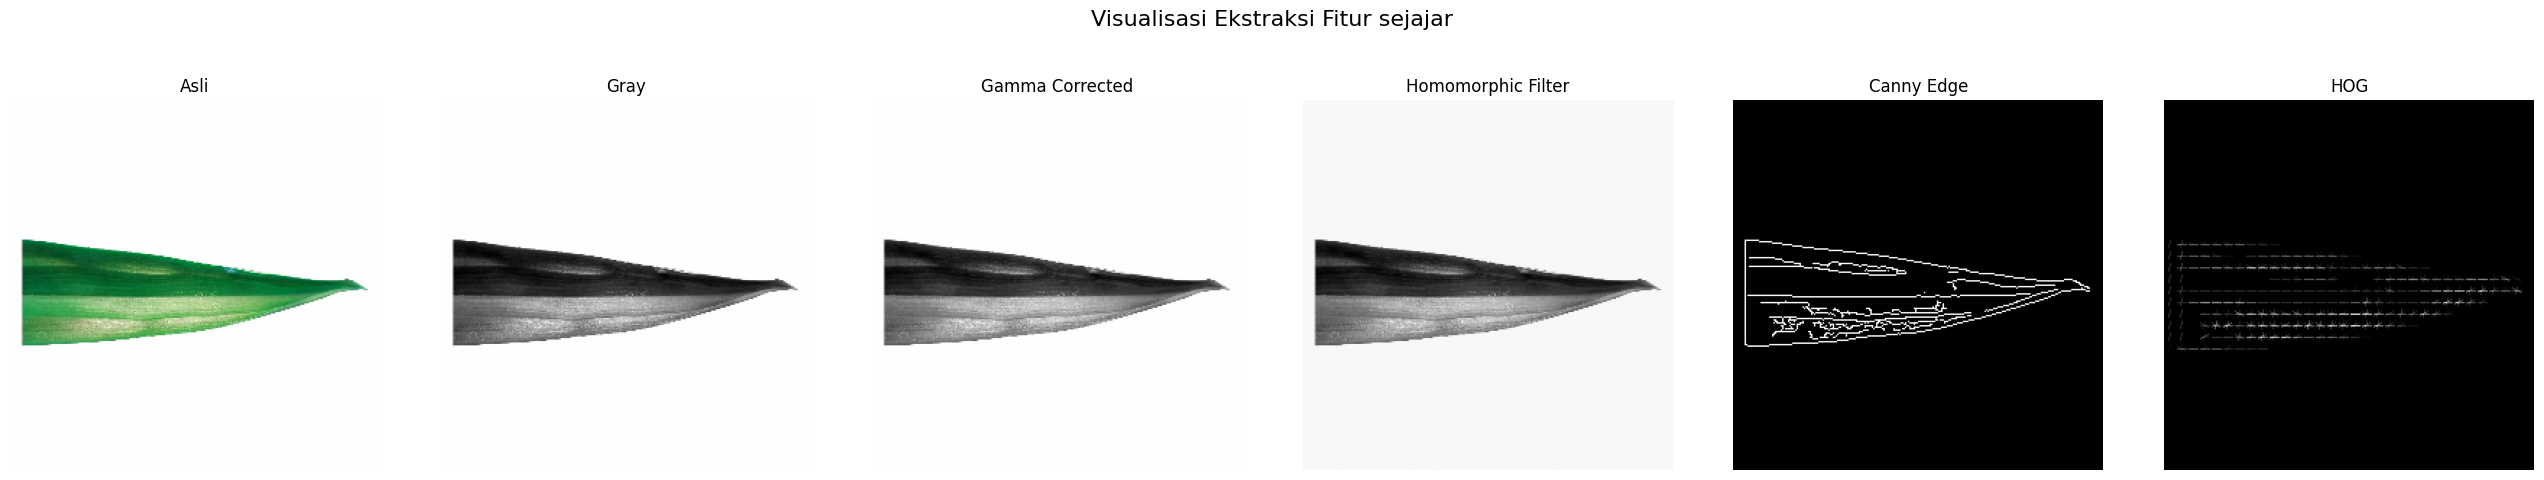

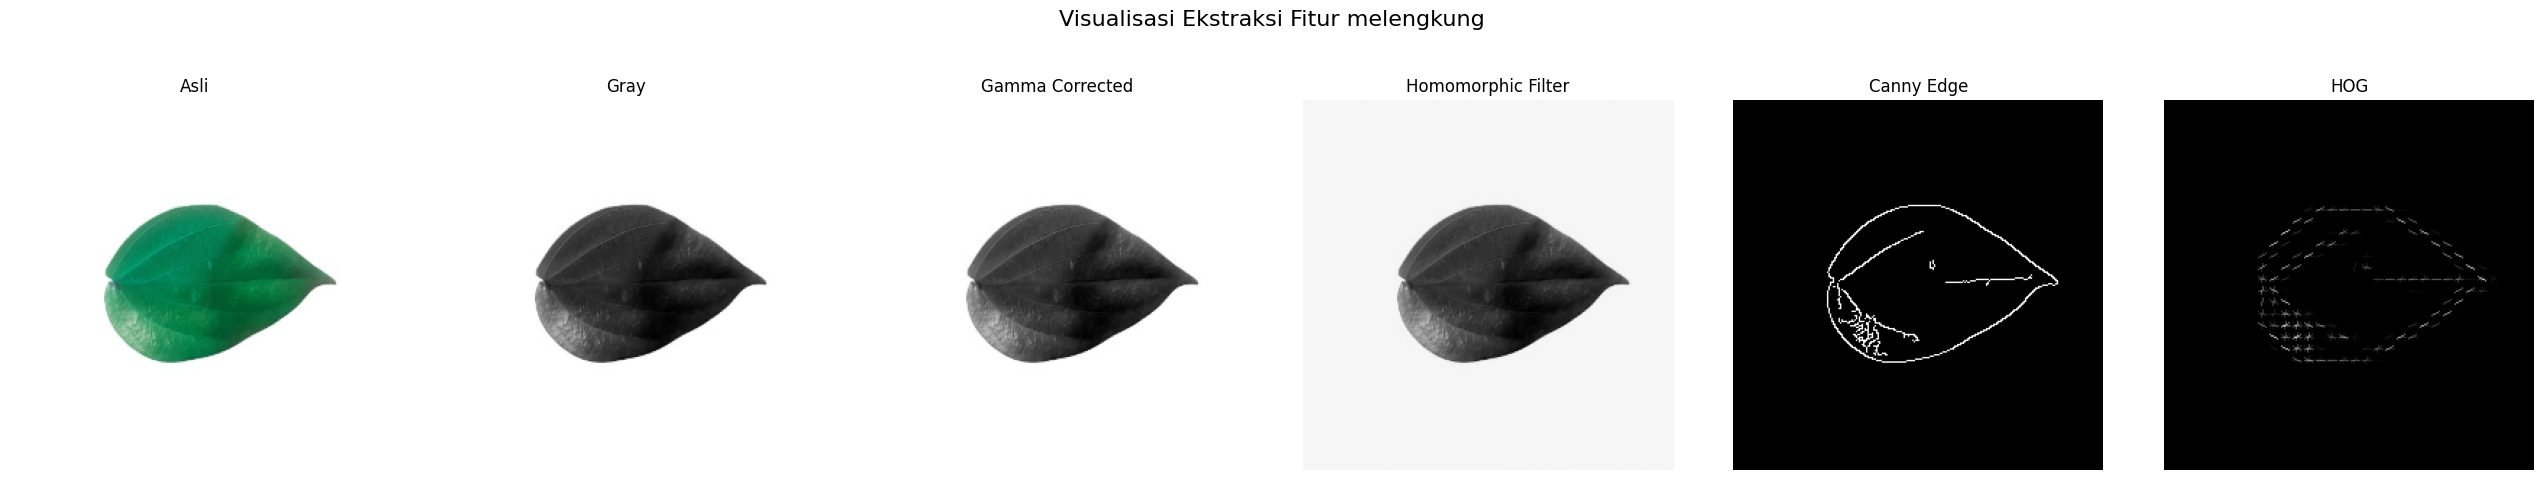

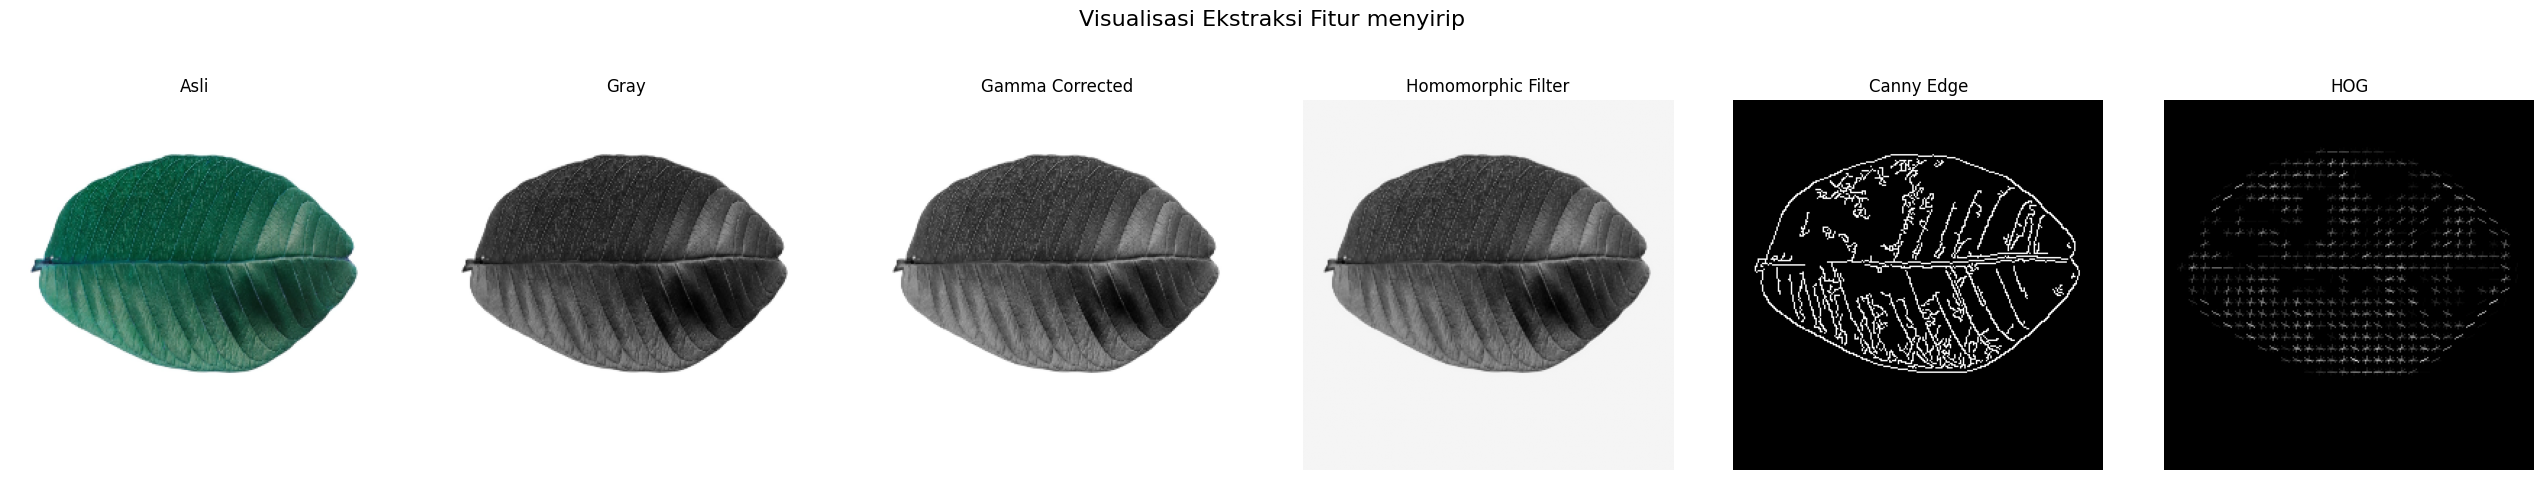

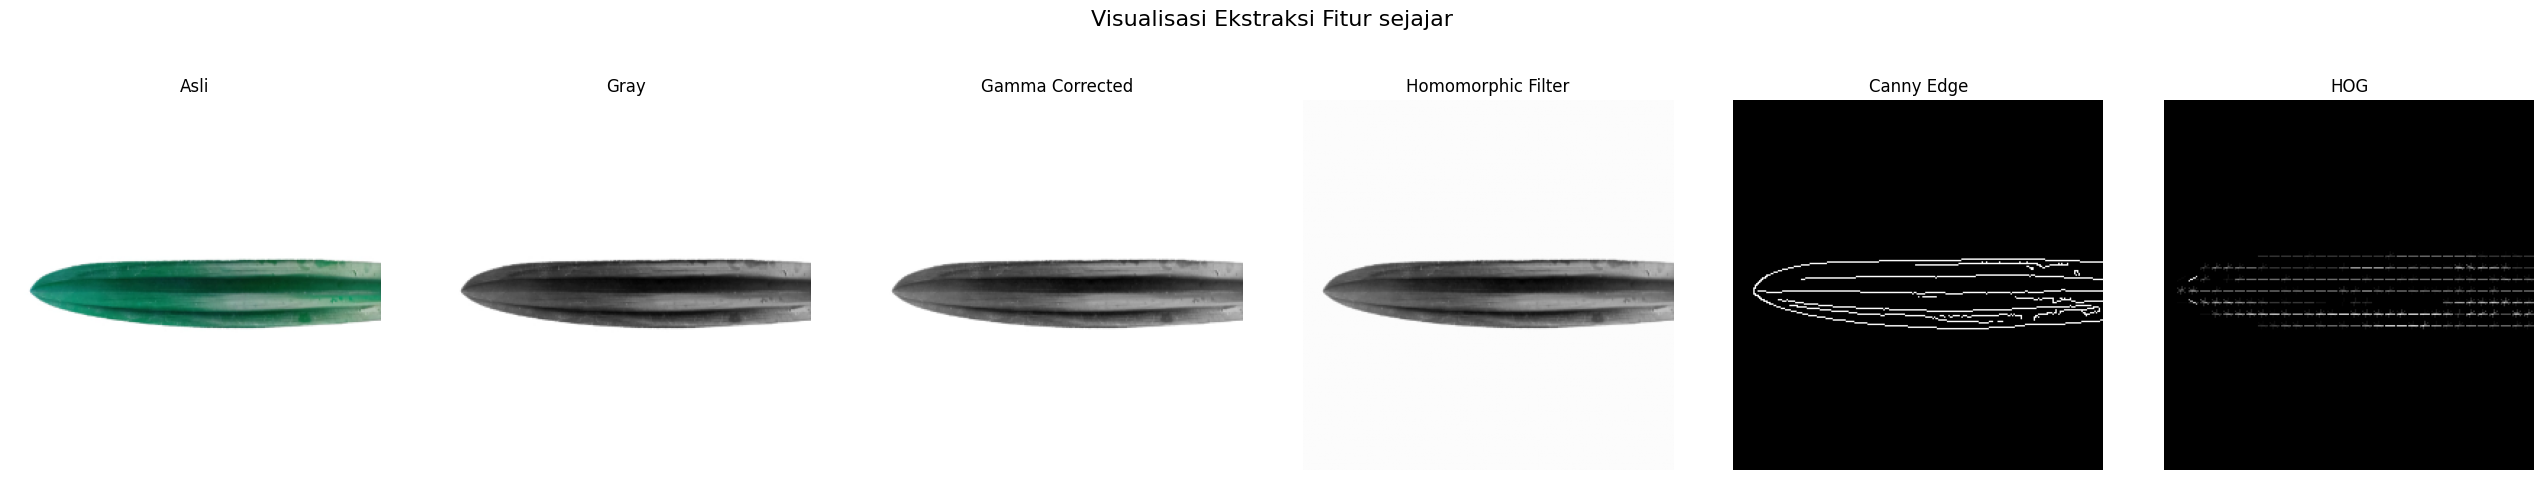

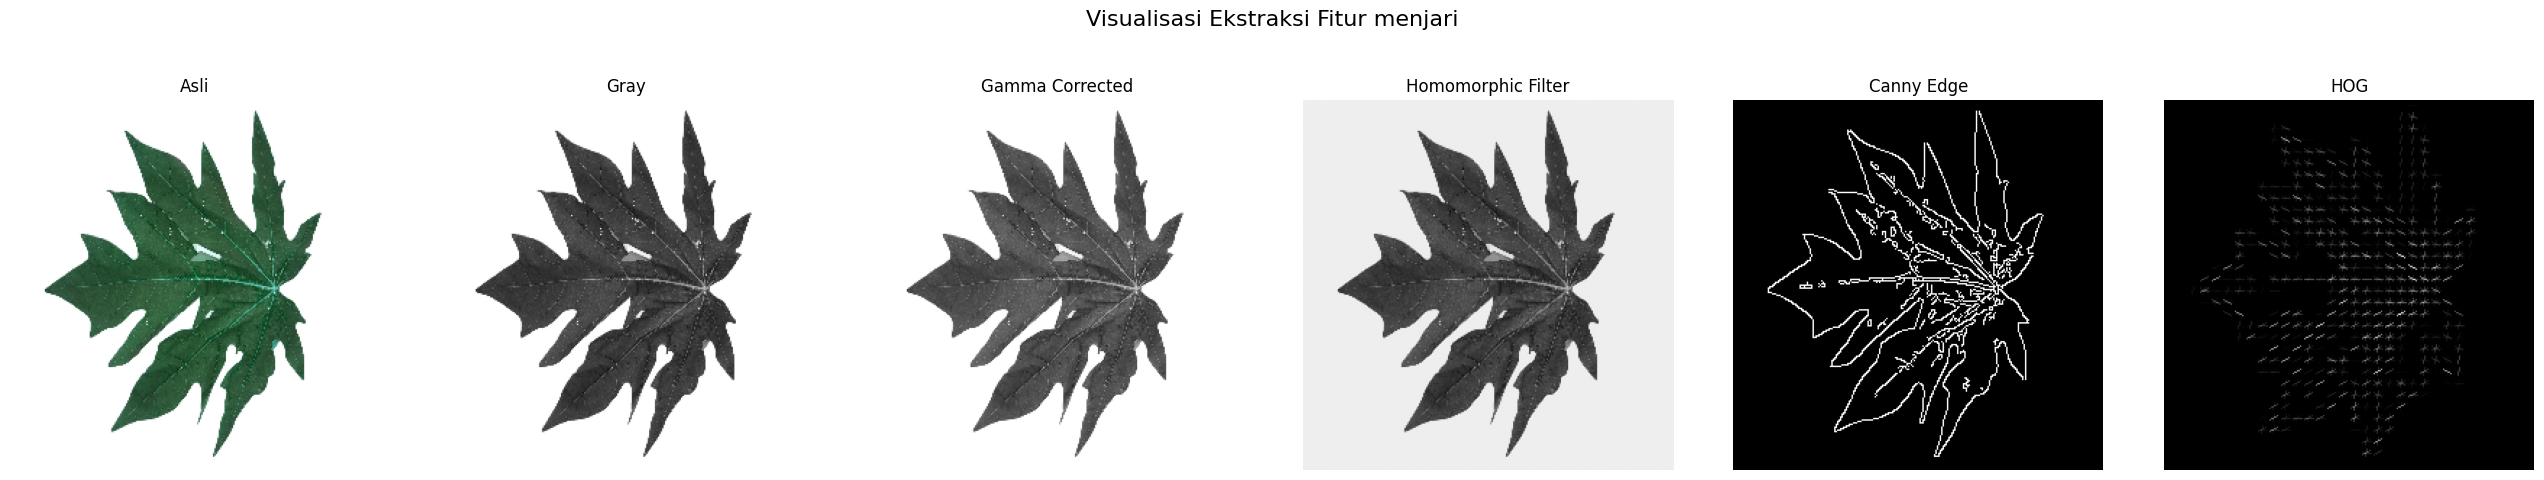

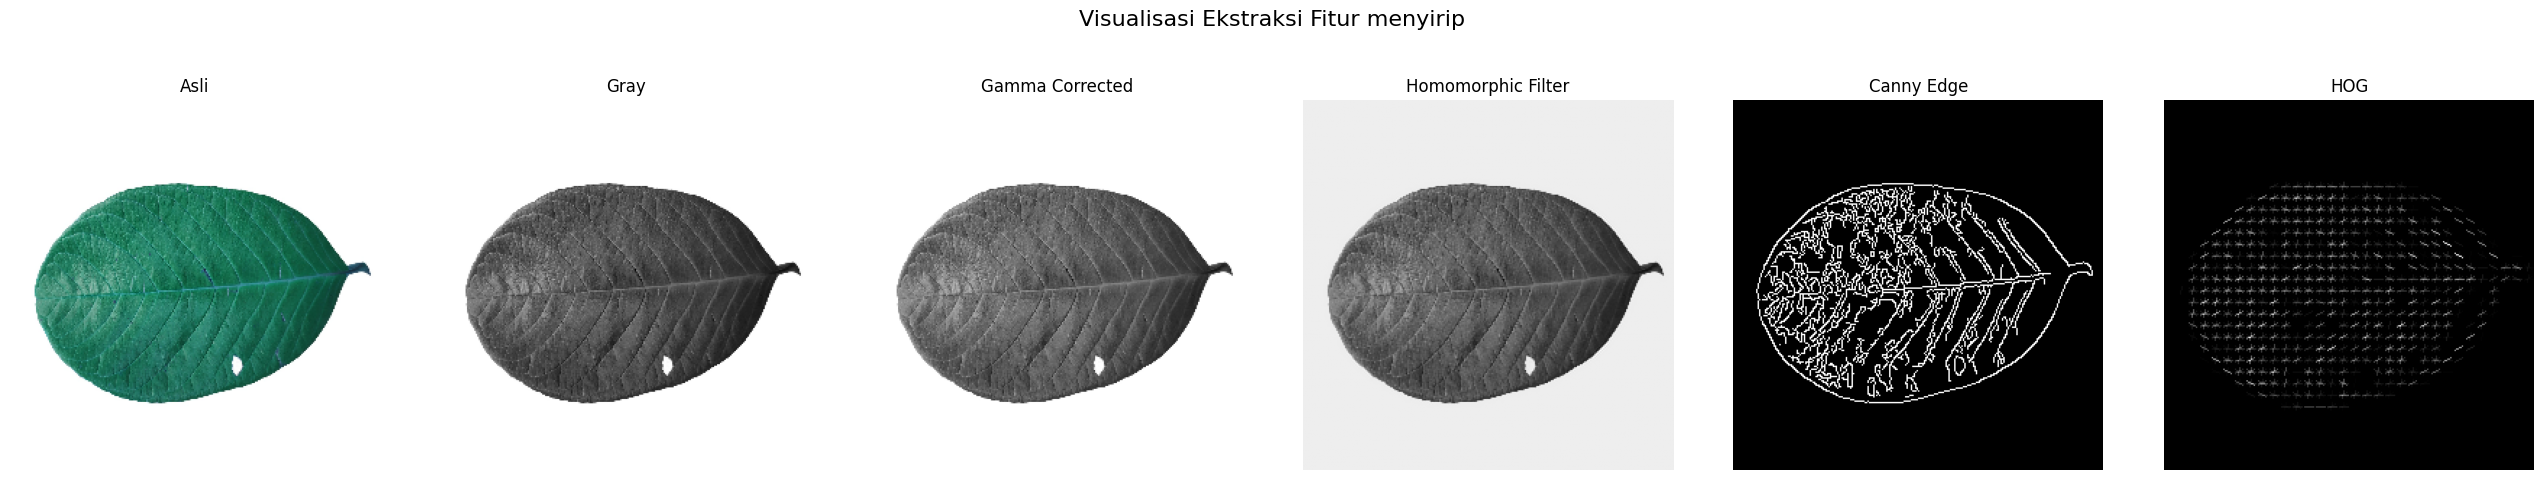

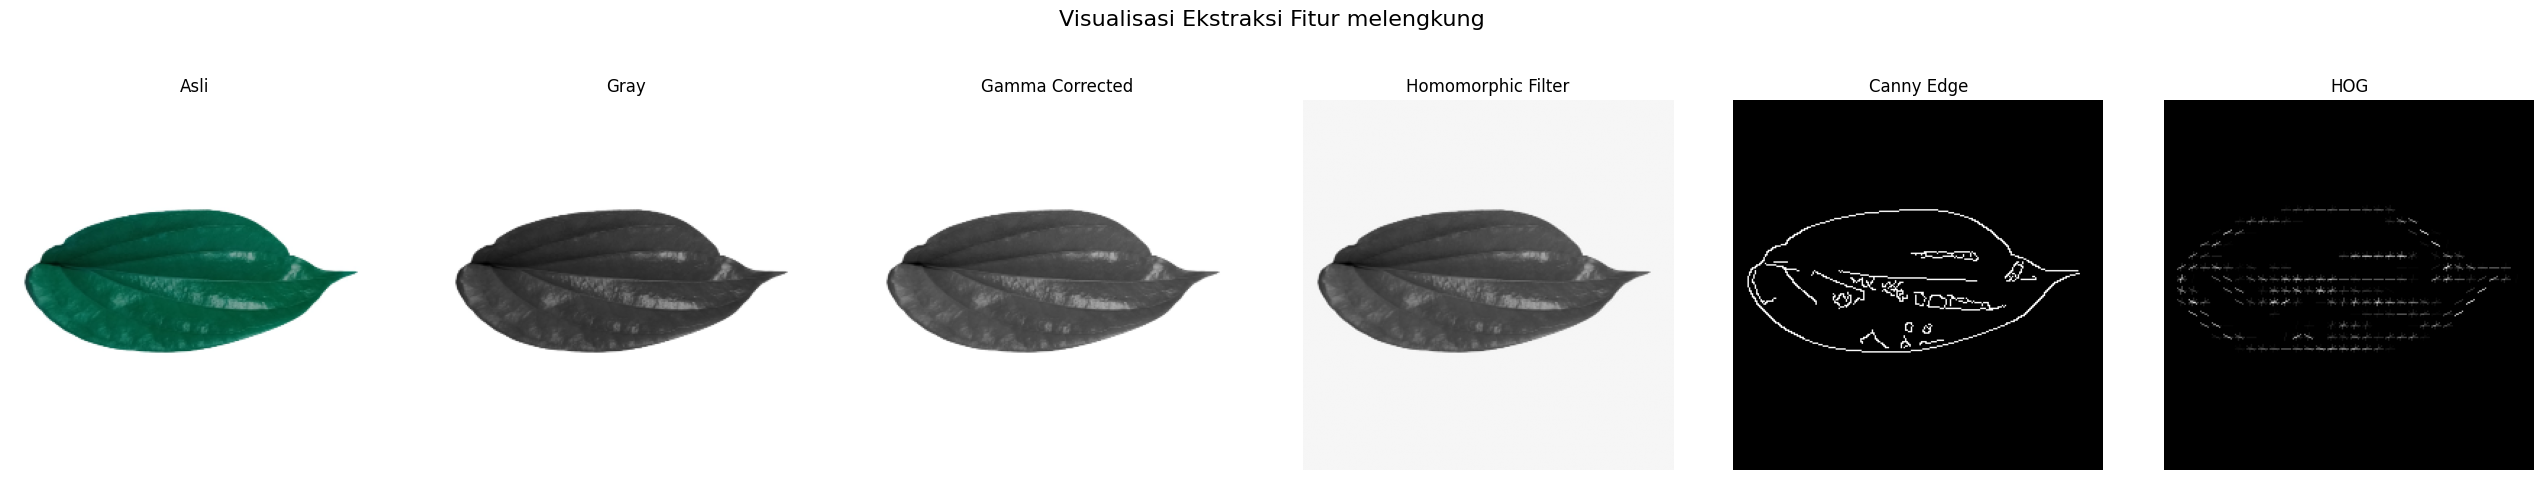

In [ ]:
train_hog_73 = hog_feature_extraction(X_train_img_73, y_train_str_73, list_label)
test_hog_73 = hog_feature_extraction(X_test_img_73, y_test_str_73, list_label)

In [ ]:
train_hog_82 = hog_feature_extraction(X_train_img_82, y_train_str_82, list_label)
test_hog_82 = hog_feature_extraction(X_test_img_82, y_test_str_82, list_label)

In [ ]:
train_hog_91 = hog_feature_extraction(X_train_img_91, y_train_str_91, list_label)
test_hog_91 = hog_feature_extraction(X_test_img_91, y_test_str_91, list_label)

# Hybrid Feature

In [ ]:
def hybrid_feature(hsv, hog):
  hybrid_feature_list = []
  for i in range(len(hsv)):
    hg = hog[i]
    hs = hsv[i]

    hybrid_feature_list.append(np.concatenate([hg, hs]))
  return hybrid_feature_list

In [ ]:
X_train_features_73 = hybrid_feature(train_hsv_73, train_hog_73)
X_test_features_73 = hybrid_feature(test_hsv_73, test_hog_73)

In [ ]:
X_train_features_82 = hybrid_feature(train_hsv_82, train_hog_82)
X_test_features_82 = hybrid_feature(test_hsv_82, test_hog_82)

In [ ]:
X_train_features_91 = hybrid_feature(train_hsv_91, train_hog_91)
X_test_features_91 = hybrid_feature(test_hsv_91, test_hog_91)

NameError: name 'train_hsv_82' is not defined

# Label Encoding

In [ ]:
def label_encoder(label):
    return list_label.index(label)

In [ ]:
y_train_73 = [label_encoder(label) for label in y_train_str_73]
y_test_73 = [label_encoder(label) for label in y_test_str_73]

In [ ]:
y_train_82 = [label_encoder(label) for label in y_train_str_82]
y_test_82 = [label_encoder(label) for label in y_test_str_82]

In [ ]:
y_train_91 = [label_encoder(label) for label in y_train_str_91]
y_test_91 = [label_encoder(label) for label in y_test_str_91]

# Classification (SVM), (RF) dan (KNN)

In [ ]:
svm_model_73 = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
rf_model_73 = RandomForestClassifier(n_estimators=100, random_state=42)
knn_model_73 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

svm_model_73.fit(X_train_features_73, y_train_73)
rf_model_73.fit(X_train_features_73, y_train_73)
knn_model_73.fit(X_train_features_73, y_train_73)

KNeighborsClassifier(metric='euclidean')

# Evalution

In [ ]:
print("Mengevaluasi model pada Test Set...")
y_pred_73 = svm_model_73.predict(X_test_features_73)
accuracy_73 = accuracy_score(y_test_73, y_pred_73)
print(f'AKURASI (HOG + SVM pada Data Cropping): {accuracy_73 * 100:.2f}%')
print("\nLaporan Klasifikasi (Cropped Data):")
print(classification_report(y_test_73, y_pred_73, target_names=list_label, zero_division=0))

Mengevaluasi model pada Test Set...
AKURASI (HOG + SVM pada Data Cropping): 93.20%

Laporan Klasifikasi (Cropped Data):
              precision    recall  f1-score   support

  melengkung       0.93      0.58      0.71        64
     menjari       0.97      0.97      0.97       105
    menyirip       0.89      0.99      0.94       226
     sejajar       1.00      0.99      1.00       105

    accuracy                           0.93       500
   macro avg       0.95      0.88      0.90       500
weighted avg       0.93      0.93      0.93       500



In [ ]:
print("Mengevaluasi model pada Test Set...")
y_pred_73 = rf_model_73.predict(X_test_features_73)
accuracy_73 = accuracy_score(y_test_73, y_pred_73)
print(f'AKURASI (HOG + Random Forest pada Data Cropping): {accuracy_73 * 100:.2f}%')
print("\nLaporan Klasifikasi (Cropped Data):")
print(classification_report(y_test_73, y_pred_73, target_names=list_label, zero_division=0))

Mengevaluasi model pada Test Set...
AKURASI (HOG + Random Forest pada Data Cropping): 86.80%

Laporan Klasifikasi (Cropped Data):
              precision    recall  f1-score   support

  melengkung       1.00      0.17      0.29        64
     menjari       0.93      0.92      0.93       105
    menyirip       0.81      0.98      0.89       226
     sejajar       0.94      0.99      0.96       105

    accuracy                           0.87       500
   macro avg       0.92      0.77      0.77       500
weighted avg       0.89      0.87      0.84       500



In [ ]:
print("Mengevaluasi model pada Test Set...")
y_pred_73 = knn_model_73.predict(X_test_features_73)
accuracy_73 = accuracy_score(y_test_73, y_pred_73)
print(f'AKURASI (HOG + KNN pada Data Cropping): {accuracy_73 * 100:.2f}%')
print("\nLaporan Klasifikasi (Cropped Data):")
print(classification_report(y_test_73, y_pred_73, target_names=list_label, zero_division=0))


Mengevaluasi model pada Test Set...
AKURASI (HOG + KNN pada Data Cropping): 82.40%

Laporan Klasifikasi (Cropped Data):
              precision    recall  f1-score   support

  melengkung       0.64      0.44      0.52        64
     menjari       0.93      0.95      0.94       105
    menyirip       0.85      0.80      0.82       226
     sejajar       0.76      0.99      0.86       105

    accuracy                           0.82       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.82      0.82      0.82       500



# Save Model

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/PBL_Dataset_Daun/model/"
os.makedirs(SAVE_PATH, exist_ok=True)

MODEL_FILENAME = SAVE_PATH + "svm_daun_model.pkl"
joblib.dump(svm_model_73, MODEL_FILENAME)
print(f"Model telah disimpan ke: {MODEL_FILENAME}")

Model telah disimpan ke: /content/drive/MyDrive/PBL_Dataset_Daun/model/svm_daun_model.pkl


In [ ]:
MODEL_FILENAME = SAVE_PATH + "rf_daun_model.pkl"
joblib.dump(rf_model_73, MODEL_FILENAME)
print(f"Model telah disimpan ke: {MODEL_FILENAME}")

Model telah disimpan ke: /content/drive/MyDrive/PBL_Dataset_Daun/model/rf_daun_model.pkl


In [ ]:
MODEL_FILENAME = SAVE_PATH + "knn_daun_model.pkl"
joblib.dump(knn_model_73, MODEL_FILENAME)
print(f"Model telah disimpan ke: {MODEL_FILENAME}")

Model telah disimpan ke: /content/drive/MyDrive/PBL_Dataset_Daun/model/knn_daun_model.pkl


In [ ]:
X_train_features_73 = np.array(X_train_features_73)

n_features = X_train_features_73.shape[1]

initial_type = [('float_input', FloatTensorType([None, n_features]))]

onnx_model = convert_sklearn(svm_model_73, initial_types=initial_type)

MODEL_FILENAME = SAVE_PATH + "svm_traffic_sign_model.onnx"
onnx.save_model(onnx_model, MODEL_FILENAME)

print(f"Model ONNX berhasil disimpan ke: {MODEL_FILENAME}")

Model ONNX berhasil disimpan ke: /content/drive/MyDrive/PBL_Dataset_Daun/model/svm_traffic_sign_model.onnx


In [ ]:
X_train_features_73 = np.array(X_train_features_73)

n_features = X_train_features_73.shape[1]

initial_type = [('float_input', FloatTensorType([None, n_features]))]

onnx_model = convert_sklearn(rf_model_73, initial_types=initial_type)

MODEL_FILENAME = SAVE_PATH + "rf_traffic_sign_model.onnx"
onnx.save_model(onnx_model, MODEL_FILENAME)

print(f"Model ONNX berhasil disimpan ke: {MODEL_FILENAME}")

Model ONNX berhasil disimpan ke: /content/drive/MyDrive/PBL_Dataset_Daun/model/rf_traffic_sign_model.onnx


In [ ]:
X_train_features_73 = np.array(X_train_features_73)

n_features = X_train_features_73.shape[1]

initial_type = [('float_input', FloatTensorType([None, n_features]))]

onnx_model = convert_sklearn(knn_model_73, initial_types=initial_type)

MODEL_FILENAME = SAVE_PATH + "knn_traffic_sign_model.onnx"
onnx.save_model(onnx_model, MODEL_FILENAME)

print(f"Model ONNX berhasil disimpan ke: {MODEL_FILENAME}")

Model ONNX berhasil disimpan ke: /content/drive/MyDrive/PBL_Dataset_Daun/model/knn_traffic_sign_model.onnx


# Test Save Model

In [ ]:
IMG_SIZE = (256, 256)

def preprocess_image_for_prediction(image_path):
    """
    Melakukan preprocessing HYBRID (HOG + Color)
    """
    try:
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            raise ValueError("Gambar tidak terbaca!")

        resized_img_bgr = cv2.resize(img_bgr, IMG_SIZE)
        resized_img_rgb = cv2.cvtColor(resized_img_bgr, cv2.COLOR_BGR2RGB)

        gray_image = rgb2gray(resized_img_rgb)
        hog_features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                           orientations=9, visualize=False)

        hsv_image = cv2.cvtColor(resized_img_bgr, cv2.COLOR_BGR2HSV)
        color_hist = cv2.calcHist([hsv_image], [0, 1], None, [16, 8], [0, 180, 0, 256])
        cv2.normalize(color_hist, color_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        color_features = color_hist.flatten()

        final_features = np.concatenate([hog_features, color_features])

        return final_features.reshape(1, -1).astype(np.float32)
    except Exception as e:
        print(f"Error preprocessing: {e}")
        return None

In [ ]:
print("Upload file model .onnx:")
MODEL_PATH = "/content/drive/MyDrive/PBL_Dataset_Daun/model/rf_traffic_sign_model.onnx"

print("\nUpload file gambar:")
uploaded_img = files.upload()
IMAGE_PATH = list(uploaded_img.keys())[0]

session = ort.InferenceSession(MODEL_PATH)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print(f"Model {MODEL_PATH} berhasil dimuat!")

features = preprocess_image_for_prediction(IMAGE_PATH)

if features is not None:
    result = session.run([output_name], {input_name: features})
    pred_index = int(result[0][0])
else:
    pred_index = None

if pred_index is not None:
    pred_name = list_label[pred_index] if pred_index < len(list_label) else "Label tidak dikenal"
    print(f"\nHasil Prediksi: {pred_name} (index: {pred_index})")
else:
    print("Gagal melakukan prediksi.")


Upload file model .onnx:

Upload file gambar:


Saving Pandan164.jpg to Pandan164.jpg
Model /content/drive/MyDrive/PBL_Dataset_Daun/model/rf_traffic_sign_model.onnx berhasil dimuat!

Hasil Prediksi: sejajar (index: 3)


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/PBL_Dataset_Daun/model/svm_daun_model.pkl"
loaded_model = joblib.load(MODEL_PATH)

single_features_reshaped = preprocess_image_for_prediction(IMAGE_PATH)

prediction_index = loaded_model.predict(single_features_reshaped)[0]
prediction_label_str = list_label[prediction_index] if prediction_index < len(list_label) else "Label tidak dikenal"

print(f"\nHasil Prediksi")
print(f"Label Sebenarnya: {prediction_index}")
print(f"Label Prediksi  : {prediction_label_str}")


Hasil Prediksi
Label Sebenarnya: 3
Label Prediksi  : sejajar


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/PBL_Dataset_Daun/model/knn_daun_model.pkl"
knn_model = joblib.load(MODEL_PATH)

pred = knn_model.predict(sample)
prediction_label_str = list_label[prediction_index] if prediction_index < len(list_label) else "Label tidak dikenal"

print("Hasil Prediksi:", pred[0])
print("Label Asli:", y_test_73[0])
print("Label Prediksi :", prediction_label_str)

Hasil Prediksi: 3
Label Asli: 3
Label Prediksi : sejajar
